In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [92]:
df['count'] = 1
df.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [93]:
# Binning by 15 mins
df = df.set_index('login_time')
df_15min = df.groupby(pd.Grouper(freq='15Min')).sum()
df_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


# Plot below shows there is a seasonality

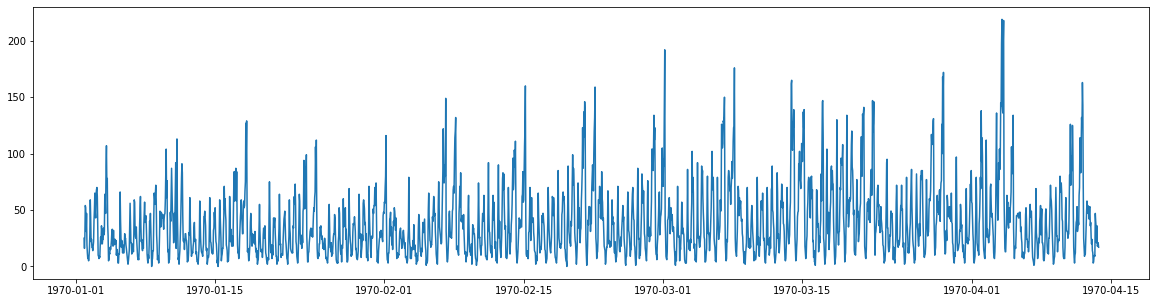

In [46]:
fig = plt.figure(figsize=(20,5))
plt.plot(df_15min['count'].resample('1H').sum())

In [95]:
df_15min['diff_days'] = (df_15min.index.to_series() - pd.to_datetime('1970-01-01 00:00:00')).dt.days
df_15min['diff_days'].fillna(0, inplace=True)
df_15min.head()

,count,diff_days
login_time,,
1970-01-01 20:00:00,2,0
1970-01-01 20:15:00,6,0
1970-01-01 20:30:00,9,0
1970-01-01 20:45:00,7,0
1970-01-01 21:00:00,1,0


In [102]:
df_15min['diff_days'].max()

102

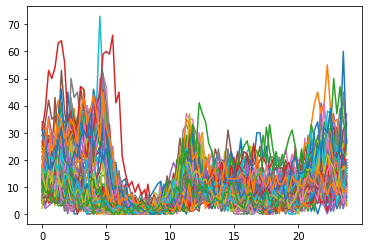

In [103]:
for d in range(103):
    df_per_day = df_15min[df_15min.diff_days == d]
    hours = df_per_day.reset_index()['login_time'].dt.hour + df_per_day.reset_index()['login_time'].dt.minute/60.
    plt.plot(hours, df_per_day['count'])
plt.show()

# Plot above looks busy, so I'm taking median

In [119]:
df_15min['hour'] = df_15min.index.to_series().dt.hour
df_15min['minute'] = df_15min.index.to_series().dt.minute
df_15min.head()

,count,diff_days,hour,minute
login_time,,,,
1970-01-01 20:00:00,2,0,20,0
1970-01-01 20:15:00,6,0,20,15
1970-01-01 20:30:00,9,0,20,30
1970-01-01 20:45:00,7,0,20,45
1970-01-01 21:00:00,1,0,21,0


In [120]:
df_15min['hour'] = df_15min['hour'] + df_15min['minute']/60.
df_15min.drop(['minute'], axis=1, inplace=True)
df_15min.drop(['diff_days'], axis=1, inplace=True)
df_15min.head()

,count,diff_days,hour
login_time,,,
1970-01-01 20:00:00,2,0,20.00
1970-01-01 20:15:00,6,0,20.25
1970-01-01 20:30:00,9,0,20.50
1970-01-01 20:45:00,7,0,20.75
1970-01-01 21:00:00,1,0,21.00


# Smoothing data by taking median per hour from all observations, show there are 12 and 24 hours cycles

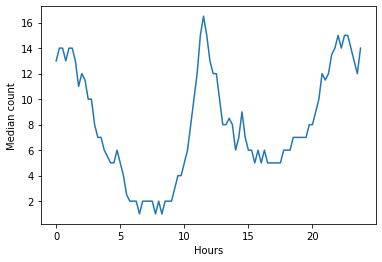

In [134]:
plt.plot(df_15min.groupby('hour').median()['count'])
plt.xlabel('Hours')
plt.ylabel('Median count')
plt.show()

# This is confirmed by using autocorrelation function.

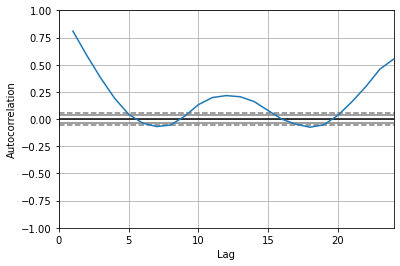

In [137]:
pd.plotting.autocorrelation_plot(df_15min['count'].resample('1H').sum())
plt.xlim([0,24])
plt.show()

# There are two peaks in 12 and 24 hours, which is above the gray line (so, it's significant)